# Deep Convolutional Neural Network Architecture for Facial Emotion Recognition

This notebook demonstrates the process of using TensorFlow to classify facial emotions using the FER2013+ dataset. The steps include downloading the dataset, preprocessing, model training, and evaluation.

## Introduction

This project aims to build a convolutional neural network (CNN) to classify facial emotions using the FER2013+ dataset. The FER2013+ dataset contains 48x48 pixel grayscale images of faces.

## Setup

First, we set up the environment and import necessary libraries.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pickle

To begin with, we need to download the FER2013+ dataset from Kaggle. This dataset contains facial emotion recognition data that we will use for our classification task. We use the `opendatasets` library for this purpose.

In [3]:
import opendatasets as od

dataset_url = "https://www.kaggle.com/datasets/subhaditya/fer2013plus"
dataset_path = od.download(dataset_url)

print(f"Dataset downloaded")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/subhaditya/fer2013plus


100%|██████████| 132M/132M [00:14<00:00, 9.77MB/s] 



Dataset downloaded


### Loading and Preprocessing the Data

We start by setting up the necessary configurations for loading the FER2013+ dataset for facial emotion recognition. We use TensorFlow's `ImageDataGenerator` to augment and preprocess the images.

In [3]:
#Getting the data
tf.random.set_seed(42)
batch_size = 128
target_size = (48,48)
train_dir = "fer2013plus/fer2013plus/fer2013/train/"
test_dir = "fer2013plus/fer2013plus/fer2013/test/"
train_dataGenerator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                               horizontal_flip=True,
                                                               validation_split=0.2)
train_ds = train_dataGenerator.flow_from_directory(train_dir,
                                                        batch_size=batch_size,
                                                        target_size=target_size, 
                                                        shuffle=True,
                                                        class_mode='categorical',
                                                        color_mode="grayscale", 
                                                        subset='training')
validation_ds = train_dataGenerator.flow_from_directory(train_dir,
                                                        batch_size=batch_size,
                                                        target_size=target_size,
                                                        shuffle=True,
                                                        class_mode='categorical',
                                                        color_mode="grayscale", 
                                                        subset='validation')

test_dataGenerator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                              horizontal_flip=True)
test_ds = test_dataGenerator.flow_from_directory(test_dir,
                                                  batch_size=batch_size,
                                                  target_size=target_size,
                                                  shuffle=True,
                                                  color_mode="grayscale", 
                                                  class_mode="categorical")

Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.


# Model Architecture Definition

## Overview

This function defines a Deep Convolutional Neural Network (DCNN) for image classification tasks, particularly suited for facial emotion recognition in the FER2013+ dataset.

In [4]:
def build_dcnn(input_shape, num_classes):
    model_in = Input(shape=input_shape, name="input")
    
    conv2d_1 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        
        kernel_initializer='he_normal',  
        
        name='conv2d_1'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(batchnorm_2)
    
    dropout_1 = Dropout(0.3, name='dropout_1')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(batchnorm_4)
    dropout_2 = Dropout(0.3, name='dropout_2')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(batchnorm_6)

    dropout_3 = Dropout(0.3, name='dropout_3')(maxpool2d_3)

    flatten = Flatten(name='flatten')(dropout_3)
    
    dense_1 = Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7')(dense_1)
    dropout_4 = Dropout(0.4, name='dropout_4')(batchnorm_7)

    model_out = Dense(
        num_classes,
        activation='softmax',
        name='out_layer',
        kernel_initializer=tf.keras.initializers.HeNormal()
    )(dropout_4)

    model = Model(inputs=model_in, outputs=model_out, name="DCNN")
    
    return model

## Model Summary

In [5]:
model = build_dcnn(input_shape=(48,48,1), num_classes=8)
model.summary() 

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0      

In [6]:
model.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(0.01),
             metrics=["accuracy"])

# Callback Functions

## Early Stopping
- Stops training early when validation loss stops improving.

## Learning Rate Scheduler
- Adjusts learning rate based on validation accuracy.

## Model Checkpoint
- Saves the best model based on validation accuracy.

In [7]:
#Callback functions
early_stopping = EarlyStopping(
    monitor='val_loss',    
    min_delta=0.00001,      
    patience=8,            
    verbose=1,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',  #val_loss no overfitting   
    min_delta=0.0001,  
    mode="min",
    factor=0.5,                 
    patience=6,                 
    min_lr=1e-7,                
    verbose=1                   
)

checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', 
                         verbose=1, save_best_only=True, mode='max')

Model will also be trained with augmented data for comparision purposes later.

In [8]:
# aug_datagen = ImageDataGenerator(
#     width_shift_range=0.15,
#     height_shift_range=0.15,
#     shear_range=0.15,
#     zoom_range=0.15,
#     horizontal_flip=True,
#     validation_split=0.2
# )
# aug_train_ds = aug_datagen.flow_from_directory(train_dir,
#                                                target_size=target_size,
#                                               batch_size=batch_size,
#                                               color_mode="grayscale",
#                                               class_mode="categorical",
#                                               subset="training")
# aug_validation_ds = aug_datagen.flow_from_directory(train_dir,
#                                                target_size=target_size,
#                                               batch_size=batch_size,
#                                               color_mode="grayscale",
#                                               class_mode="categorical",
#                                               subset="validation")

Training the model with all the `callbacks` created

In [11]:
#Fitting the data
import time
start = time.time()
history = model.fit(train_ds,
                    steps_per_epoch=len(train_ds),
                    validation_steps=int(0.25*len(test_ds)),
                   validation_data = validation_ds,
                   epochs=100,
                   callbacks=[early_stopping, lr_scheduler, checkpoint])
end = time.time()
print(end-start)

Epoch 1/100


178/178 [==============================] - ETA: 0s - loss: 1.4564 - accuracy: 0.4974
Epoch 1: val_accuracy improved from -inf to 0.53460, saving model to model.h5
178/178 [==============================] - 28s 115ms/step - loss: 1.4564 - accuracy: 0.4974 - val_loss: 1.3577 - val_accuracy: 0.5346 - lr: 0.0100
Epoch 2/100
  1/178 [..............................] - ETA: 22s - loss: 1.1914 - accuracy: 0.5391

/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


178/178 [==============================] - ETA: 0s - loss: 0.9979 - accuracy: 0.6487
Epoch 2: val_accuracy improved from 0.53460 to 0.62667, saving model to model.h5
178/178 [==============================] - 18s 102ms/step - loss: 0.9979 - accuracy: 0.6487 - val_loss: 1.0393 - val_accuracy: 0.6267 - lr: 0.0100
Epoch 3/100
178/178 [==============================] - ETA: 0s - loss: 0.8482 - accuracy: 0.6997
Epoch 3: val_accuracy improved from 0.62667 to 0.67355, saving model to model.h5
178/178 [==============================] - 18s 102ms/step - loss: 0.8482 - accuracy: 0.6997 - val_loss: 0.9190 - val_accuracy: 0.6735 - lr: 0.0100
Epoch 4/100
178/178 [==============================] - ETA: 0s - loss: 0.7778 - accuracy: 0.7253
Epoch 4: val_accuracy improved from 0.67355 to 0.73047, saving model to model.h5
178/178 [==============================] - 18s 103ms/step - loss: 0.7778 - accuracy: 0.7253 - val_loss: 0.7743 - val_accuracy: 0.7305 - lr: 0.0100
Epoch 5/100
178/178 [================

### Evaluating and saving the model

In [10]:
model.evaluate(test_ds)

56/56 [==============================] - 7s 118ms/step - loss: 0.5810 - accuracy: 0.8065


[0.5810478329658508, 0.8064516186714172]

In [41]:
history.history["val_accuracy"][-1]

0.8142403960227966

In [ ]:
model.save("model.h5")

In [13]:
import tensorflow as tf
import visualkeras
from PIL import Image

model = tf.keras.models.load_model('model.h5')

# Plot the model architecture
image = visualkeras.layered_view(model, legend=False)
width, height = 3000, 1000
image = image.resize((width, height))

image.save("visualkeras.png")

### Creating a function which creates json files by taking in pickle files of various models for further analysis

In [ ]:
def json_dump(filepath: str = "", filenames: list = [], dicts: list = []) -> None:
    """
    Saves dictionary variables as json files

    Args:
    filepath (str): path to save the file. Default is current directory
    filename (list of strings): names for each saved file
    dicts (list of dictionaires): data to be stored in a file

    Returns: None

    """
    import json
    if (len(filenames) != len(dicts)):
        raise ValueError("Input size Incompatible")
    for i in range(len(filenames)):
        python_obj = eval(str(dicts[i]))
        json_obj = json.dumps(python_obj,indent=4)
        with open(f"{filepath}/{filenames[i]}","w") as file:
            file.write(json_obj)


In [ ]:
filenames = [f.split(".pkl")[0]+".json" for f in os.listdir("history_var/")]
dicts = [pickle.load(f) for f in os.listdir("history_var")]
json_dumps(filepath='hist_dict',
            filenames=filenames,
            dicts=dicts)

### Visualisisng the model performance

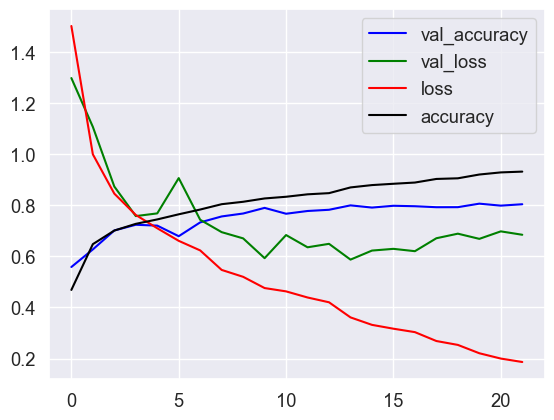

In [100]:
plt.plot(history.history["val_accuracy"], color="blue")
plt.plot(history.history["val_loss"], color="green")
plt.plot(history.history["loss"], color="red")
plt.plot(history.history["accuracy"], color="black")
plt.legend(["val_accuracy","val_loss","loss", "accuracy"])
plt.show()

### Loading in a model that is trained in the exact same way but the input data is augmented

In [12]:
with open("history_var/hist_dcnn.pkl", 'rb') as pickle_file:
    history_no_aug = pickle.load(pickle_file)
    history_no_aug = history_no_aug.history

with open("history_var/augmented_dcnn.pkl", 'rb') as pickle_file:
    history_aug = pickle.load(pickle_file)

Text(0.5, 0, 'epochs')

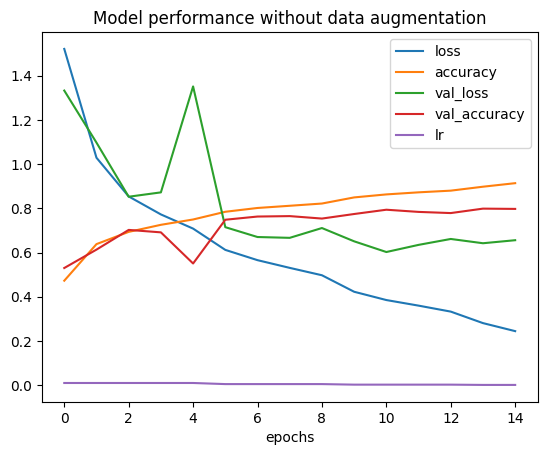

In [13]:
pd.DataFrame(history_no_aug).plot()
plt.title("Model performance without data augmentation")
plt.xlabel("epochs")

Text(0.5, 0, 'epochs')

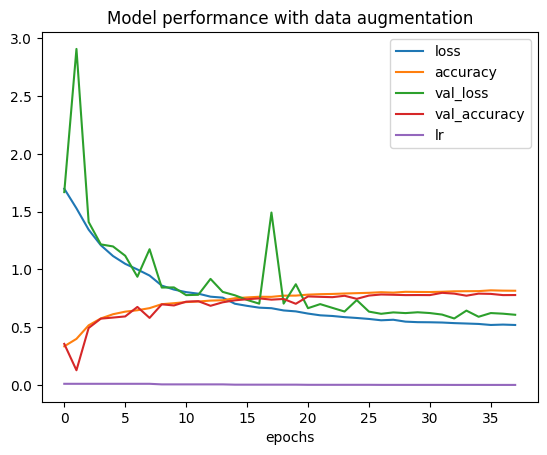

In [14]:
pd.DataFrame(history_aug).plot()
plt.title("Model performance with data augmentation")
plt.xlabel("epochs")

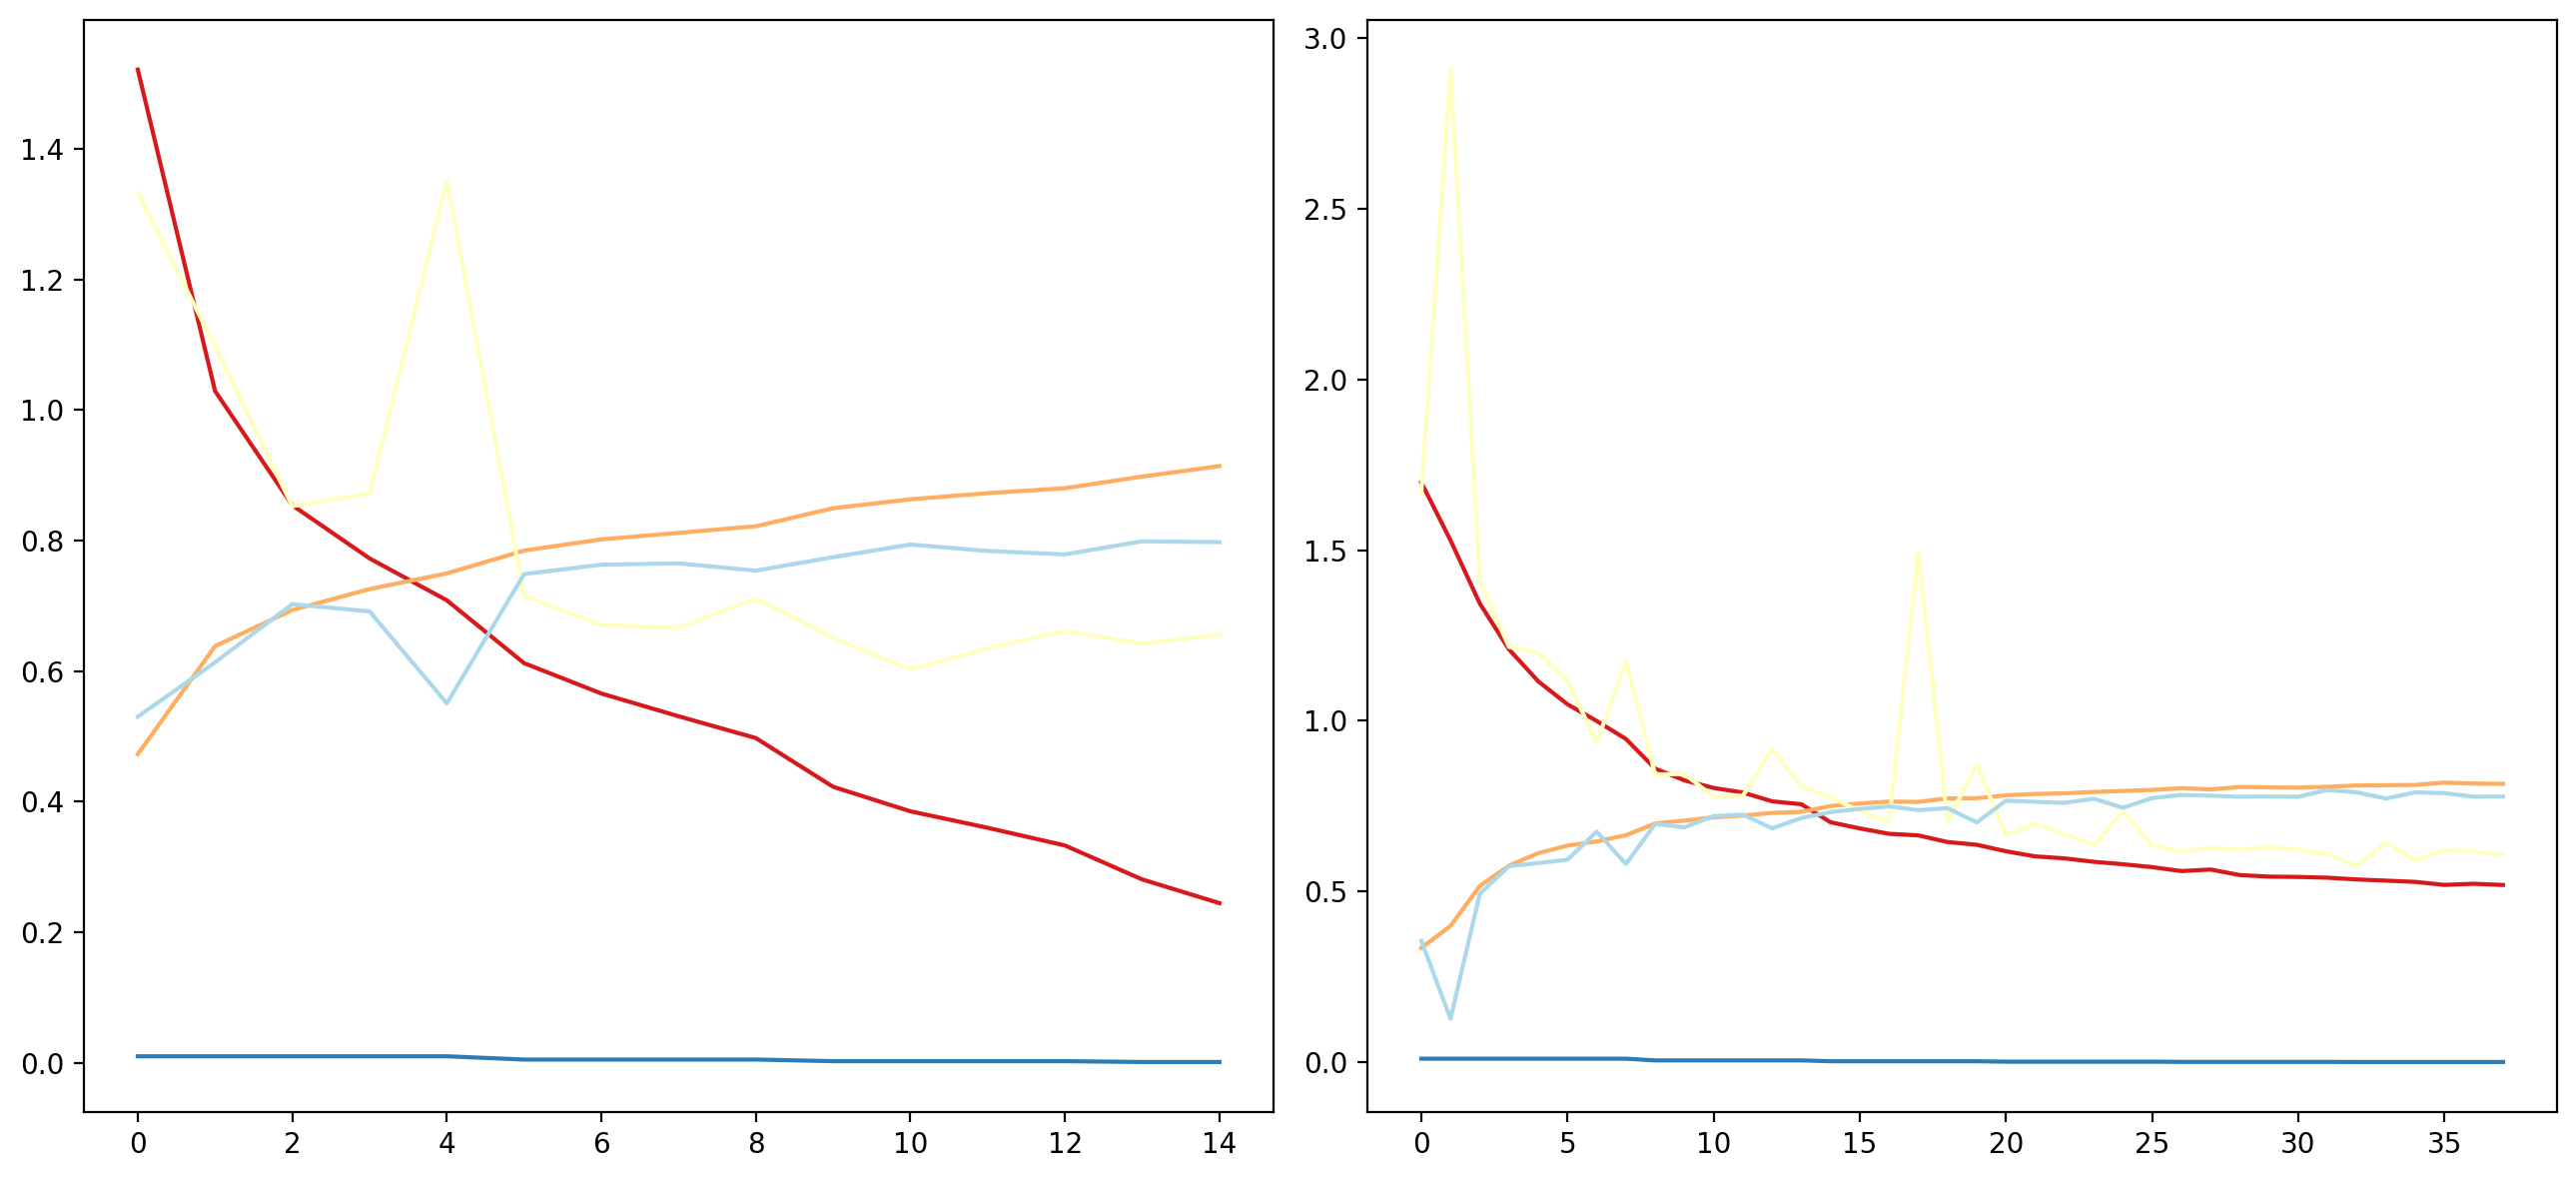

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(13, 6), dpi=200)  # Adjust figsize to meet the pixel requirements
colour = ['#d7191c','#fdae61','#ffffbf','#abd9e9','#2c7bb6']

# Plot the first dataframe in the first subplot
pd.DataFrame(history_no_aug).plot(ax=axs[0], color=colour, legend=False)
# axs[0].set_title('Model performance for Regular Images')

pd.DataFrame(history_aug).plot(ax=axs[1], color=colour, legend=False)
# axs[1].set_title('Model performance for Augmented Images')
# fig.suptitle('Comparison of Model performance regarding Image Augmentation', fontsize=15)

plt.tight_layout()
plt.savefig('augvsnoaug.png', dpi=200)

Model trained with augmented data performs better with less noise while training because it is able to generalise the data very well compared to that model which is trained on non-augmented data